[(-4.8, 4.8), (-0.5, 0.5), (-0.41887903, 0.41887903), (-0.8726646259971648, 0.8726646259971648)]
4
(4, 2)
-4.8
Episode 0 finished after 14 time steps
Episode 100 finished after 14 time steps
Episode 200 finished after 149 time steps
Episode 300 finished after 200 time steps
Episode 400 finished after 177 time steps
Episode 500 finished after 41 time steps
Episode 600 finished after 186 time steps
Episode 700 finished after 46 time steps
Episode 800 finished after 108 time steps
Episode 900 finished after 200 time steps


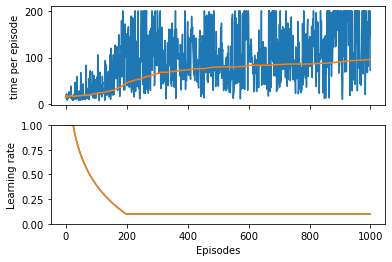

In [23]:
import gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')

no_buckets = (1, 1, 6, 12)
no_actions = env.action_space.n

state_value_bounds = list(zip(env.observation_space.low,
                              env.observation_space.high))
state_value_bounds[1] = (-0.5, 0.5)
state_value_bounds[3] = (-math.radians(50), math.radians(50))

print(state_value_bounds)
print(len(state_value_bounds))
print(np.shape(state_value_bounds))
print(state_value_bounds[0][0])


action_index = len(no_buckets)   # i am not using this

# define q_value_table
q_value_table = np.zeros(no_buckets + (no_actions,))

# Q has 6 dimensions 1 x 1 x 6 x 3 x 2
#print(q_value_table)


# user-defined parameters
min_explore_rate = 0.1
min_learning_rate = 0.1
max_episodes = 1000
max_time_steps = 250
streak_to_end = 120
solved_time = 199
discount = 0.99
no_streaks = 0

# Select an action - explore vs exploit
# epsilon-greedy method


def select_action(state_value, explore_rate):
    if random.random() < explore_rate:
        action = env.action_space.sample()    # explore
    else:
        action = np.argmax(q_value_table[state_value])  # exploit
    return action


def select_explore_rate(x):
    # change the exploration rate over time.
    return max(min_learning_rate, min(1.0, 1.0 - math.log10((x+1)/25)))


def select_learning_rate(x):
    # Change learning rate over time
    return max(min_learning_rate, min(1.0, 1.0 - math.log10((x+1)/25)))


def bucketize_state_value(state_value):
    ''' Discretizes continuous values into fixed buckets'''
    #print('len(state_value):', len(state_value))
    bucket_indices = []
    for i in range(len(state_value)):
        if state_value[i] <= state_value_bounds[i][0]:   # violates lower bound
            bucket_index = 0
        elif state_value[i] >= state_value_bounds[i][1]:  # violates upper bound
            bucket_index = no_buckets[i] - 1  # put in the last bucket
        else:
            bound_width = state_value_bounds[i][1] - state_value_bounds[i][0]
            offset = (no_buckets[i]-1) * state_value_bounds[i][0] / bound_width
            scaling = (no_buckets[i]-1) / bound_width
            bucket_index = int(round(scaling*state_value[i]-offset))

        bucket_indices.append(bucket_index)
    return(tuple(bucket_indices))


def discretize(obs):
    ''' Does the same job as bucketize'''
    upper_bounds = [state_value_bounds[i][1] for i in range(len(obs))]
    lower_bounds = [state_value_bounds[i][0] for i in range(len(obs))]
    ratios = [(obs[i] + abs(lower_bounds[i])) /
              (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
    new_obs = [int(round((no_buckets[i] - 1) * ratios[i]))
               for i in range(len(obs))]
    new_obs = [min(no_buckets[i] - 1, max(0, new_obs[i]))
               for i in range(len(obs))]
    return tuple(new_obs)


# main program
if __name__ == '__main__':

    _DEBUG = False
    frames = []
    reward_per_episode = []
    time_per_episode = []
    avgtime_per_episode = []
    learning_rate_per_episode = []
    explore_rate_per_episode = []

    # train the system
    totaltime = 0
    for episode_no in range(max_episodes):

        explore_rate = select_explore_rate(episode_no)
        learning_rate = select_learning_rate(episode_no)

        learning_rate_per_episode.append(learning_rate)
        explore_rate_per_episode.append(explore_rate)

        # reset the environment while starting a new episode
        observation = env.reset()

        start_state_value = bucketize_state_value(observation)
        previous_state_value = start_state_value

        done = False
        time_step = 0

        while not done:
            #env.render()
            action = select_action(previous_state_value, explore_rate)
            observation, reward_gain, done, info = env.step(action)
            state_value = bucketize_state_value(observation)
            best_q_value = np.max(q_value_table[state_value])

            #update q_value_table
            q_value_table[previous_state_value][action] += learning_rate * (
                reward_gain + discount * best_q_value -
                q_value_table[previous_state_value][action])

            previous_state_value = state_value

            if episode_no % 100 == 0 and _DEBUG == True:
                print('Episode number: {}'.format(episode_no))
                print('Time step: {}'.format(time_step))
                print('Previous State Value: {}'.format(previous_state_value))
                print('Selected Action: {}'.format(action))
                print('Current State: {}'.format(str(state_value)))
                print('Reward Obtained: {}'.format(reward_gain))
                print('Best Q Value: {}'.format(best_q_value))
                print('Learning rate: {}'.format(learning_rate))
                print('Explore rate: {}'.format(explore_rate))

            time_step += 1
            # while loop ends here

        if time_step >= solved_time:
            no_streaks += 1
        else:
            no_streaks = 0

        if no_streaks > streak_to_end:
            print('CartPole problem is solved after {} episodes.'.format(episode_no))
            print('Learning rate at which it is solved: {}'.format(learning_rate))
            break

        # data log
        if episode_no % 100 == 0:
            print('Episode {} finished after {} time steps'.format(
                episode_no, time_step))
        time_per_episode.append(time_step)
        totaltime += time_step
        avgtime_per_episode.append(totaltime/(episode_no+1))
        # episode loop ends here

    env.close()

    # Plotting
    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].plot(time_per_episode)
    axes[0].plot(avgtime_per_episode)
    axes[0].set(ylabel='time per episode')
    axes[1].plot(learning_rate_per_episode)
    axes[1].plot(explore_rate_per_episode)
    axes[1].set_ylim([0, 1])
    axes[1].set(xlabel='Episodes', ylabel='Learning rate')
    plt.savefig("cp_qlearn_plot.png")
    plt.show()
